In [72]:
import numpy as np
import sys
import time
%matplotlib notebook
import matplotlib
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.ion()
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
import ipywidgets as widgets
from ipywidgets import interact, Play, IntSlider
from sklearn.decomposition import PCA

<IPython.core.display.Javascript object>


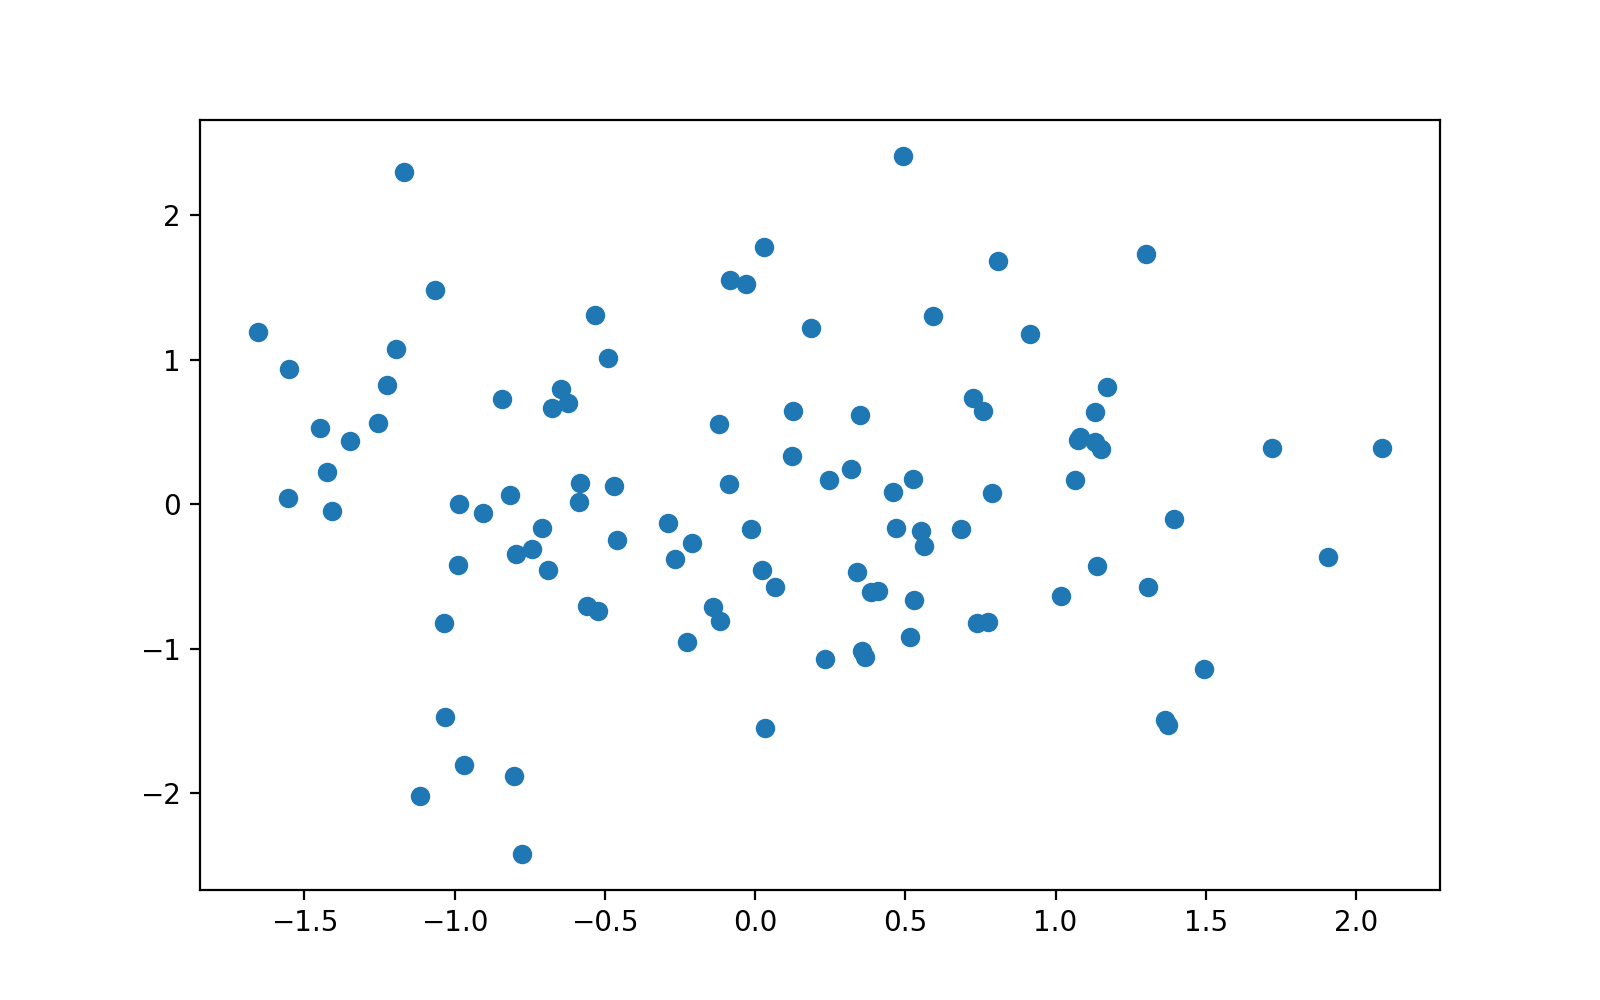

In [3]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
ax.scatter(np.random.randn(100), np.random.randn(100))

# Population Gradient Descent

The idea is to rethink gradient descent by running many small gradient descent processes in parallel, killing off the unsuccessful ones every so often and replacing them with "offspring" of the successful ones. It's evolutionary gradient descent. My guess is that it will perform worse in low dimensional spaces but better in high dimensional ones, where the chance that regular gradient descent finds a global optima is vanishingly small.

Here's the procedure:
1. Set 100 Gaussian learners loose, each with a set mean, variance, and learning rate, which is from here on to be called a genome, denoted as $(\mu, \sigma^2, \alpha)$.
2. Run gradient descent for all 100 in parallel for 10 steps.
3. Cull 80% of the herd that occupies the worst positions
4. Reproduce each survivor 4 times each to seed a new herd
5. Go back to step 2 and repeat the process.


The learners can be reproduced by sampling: sample the learner's Gaussian itself to get the new mean $\mu_{t+1}$, sample an Exponential distribution with the variance as the mean to get the new variance $\sigma^2_{t+1}$, and sample another Exponential with the learning rate as the mean to get the new learning rate $\alpha_{t+1}$.

We will learn parameters for some fully connected neural networks. The gradient descent steps will be implemented as batch gradient descent through backpropagation. In other words, each learner will be trained on the entire dataset 10 times. The main test will be to see how backpropagation as usual compares with PGD as the nets get deeper. My hypothesis is that PGD will start to perform better for nets beyond 3 or 4 layers deep.

A key variable to keep an eye on is the learning rate for backpropagation. I need to make sure this is carefully optimized so that the comparison is fair, because in PGD the learners are allowed to evolve their own learning rate.

In [40]:
np.random.randn(*np.random.randn(4, 2).shape)

array([[ 0.22745993,  1.30714275],
       [-1.60748323,  0.18463386],
       [ 0.25988279,  0.78182287],
       [-1.23695071, -1.32045661]])

In [5]:
class Individual(object):
    def __init__(self, learner_factory, stdev_init=1.0, learning_rate_init=0.1, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        self.learner_factory = learner_factory
        self.learner = learner_factory(*args, **kwargs)
        self.stdev_init = stdev_init
        self.learning_rate_init = learning_rate_init
        self.means = self.learner.weights
        # self.stdevs = [np.ones(size=means.shape) * self.stdev_init for means in self.means]
        self.stdev = self.stdev_init
        self.learning_rate = self.learning_rate_init
    
    def clone(self):
        return Individual(self.learner_factory, stdev_init=self.stdev, learning_rate_init=self.learning_rate, *self.args, **self.kwargs)
    
    def reproduce(self, num=1):
        descendants = [self.clone() for i in range(num)]
        for child in descendants:
            child.means = [self.stdev * np.random.randn(*means.shape) + means for means in self.means]
            # child.stdevs = [np.random.exponential(scale=stdevs) for stdevs in self.stdevs]
            child.stdev = np.random.exponential(scale=self.stdev)
            child.learning_rate = np.random.exponential(scale=self.learning_rate)
        return descendants

    def fit(self, X, y):
        self.learner.weights = self.means
        # self.learner.num_epochs = 10
        self.learner.learning_rate = self.learning_rate
        self.learner.fit(X, y, transfer=True)
        # self.means = self.learner.weights
    
    def score(self, X, y, **kwargs):
        return self.learner.score(X, y, **kwargs)
        

class Population(object):
    def __init__(self, individual_factory=NeuralNetworkWithPCA, num=10, cull=0.8, num_generations=10, *args, **kwargs):
        self.population = [Individual(individual_factory, stdev_init=1, learning_rate_init=0.1, *args, **kwargs) for i in range(num)]
        self.num = num
        self.cull = cull
        self.num_generations = num_generations
        self.accuracy = np.zeros((self.num_generations))
        self.mse = np.zeros((self.num_generations))
        self.population_history = list(range(self.num_generations))
        for i in range(self.num_generations):
            self.population_history[i] = list(range(self.num))
    
    def _evolve(self, X, y, generation=None):
        for individual in self.population:
            individual.fit(X, y)
        
        if generation is not None:
            self.mse[generation] = np.mean([individual.score(X, y, metric='mse') for individual in self.population])
            self.accuracy[generation] = np.mean([individual.score(X, y, metric='accuracy') for individual in self.population])
            for i in range(self.num):
                self.population_history[generation][i] = [w.copy() for w in self.population[i].learner.weights]
        
        scores = [(i, self.population[i].score(X, y, metric='mse')**-1) for i in range(self.num)]
        scores.sort(key=lambda s: s[1])
        scores.reverse()
        self.population = [self.population[s[0]] for s in scores[:round(self.num*(1-self.cull))]]
        ind = 0
        initial_num = len(self.population)
        while len(self.population) < self.num:
            self.population.extend(self.population[ind].reproduce(num=1))
            ind = (ind + 1) % initial_num
    
    def fit(self, X, y):
        for i in range(self.num_generations):
            print("Fitting generation %d of %d" % (i, self.num_generations))
            self._evolve(X, y, generation=i)
    
    def score(self, X, y, metric='accuracy'):
        return [individual.score(X, y, metric=metric) for individual in self.population]
        
        

Note: interesting idea here for future exploration: evolve an individual learning rate for each weight parameter, so that deep ravines can be kind of broadened out by effectively rescaling the fast feature by slowing down the learning rate.

In [4]:
def sigmoid(X):
    return 1. / (1. + np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * ( 1 - sigmoid(X) )

def relu(X):
    return (X + np.abs(X)) / 2.

def relu_grad(X):
#     return relu(X) - relu(X-1)
    return sigmoid(X)

class NeuralNetworkWithPCA(object):
    def __init__(self, layers=(2,2,1), learning_rate=0.1, num_epochs=10, batch_size=None, activation='relu', use_pca=(True,True,)):
        self.num_layers = len(layers)
        self.layers = layers
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.use_pca = use_pca
        self._batch_size_arg = batch_size
        
        self.nodes = list(range(self.num_layers))
        self.grad = list(range(self.num_layers))
        self.dw = list(range(self.num_layers-1))
        self.weights = list(range(self.num_layers-1))
        self.weights_history = list(range(self.num_layers-1))
        # self.nodes[0] = np.zeros(self.num_layers[0])
        for i in range(self.num_layers - 1):
            # self.nodes[i+1] = np.zeros(self.num_layers[i+1])
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1])
            self.weights_history[i] = np.zeros((self.num_epochs+1, self.layers[i], self.layers[i+1]))
            self.weights_history[i][0] = self.weights[i]

        self.activation, self.activation_grad = self._activation_function(activation)
        self.accuracy = np.zeros((self.num_epochs))
        self.mse = np.zeros((self.num_epochs))
    
    def _initialise_pca(self, X):
        Xt = X.copy()
        for i in range(self.num_layers - 1):
            Xt = self._transform(Xt, layer=i)
            if self.use_pca[i]:                
                pca = PCA(n_components=self.layers[i+1])
                pca.fit(Xt)
                for j in range(self.layers[i+1]):
                    self.weights[i].T[j] = pca.components_[j]
    
    def _activation_function(self, name):
        funcs = {
            'relu': (relu, relu_grad),
            'sigmoid': (sigmoid, sigmoid_grad),
        }
        return funcs[name]
    
    def _metrics(self, name):
        funcs = {
            'accuracy': self._accuracy,
            'mse': self._mse,
        }
        return funcs[name]

    def _transform(self, X, layer=1):
        if layer == 0:
            return X
        return self.activation(np.dot(X, self.weights[layer-1]))
    
    def _transform_history(self, X, layer=1, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        if layer == 0:
            return X
        return self.activation(np.dot(X, self.weights_history[layer-1][epoch]))
    
    def _cum_transform(self, X, layer=1):
        if layer > self.num_layers:
            raise Exception("There are only %d layers, but you specified the %dth layer" % (self.num_layers, layer))
        out = X
        for i in range(1, layer):
            out = self._transform(out, layer=i)
        return out
    
    def _forward(self, X):
        self.nodes[0] = X
        for i in range(1, self.num_layers):
            self.nodes[i] = self._transform(self.nodes[i-1], layer=i)
        self.output = self.nodes[self.num_layers-1]
        return self.output

    def _backward(self, X, y, epoch=None):
        n = X.shape[0]
        self._forward(X)
        error = y - self.output
        self.grad[self.num_layers-1] = error * self.activation_grad(self.output)
        for j in range(self.num_layers-2, -1, -1):
            self.grad[j] = np.dot(self.grad[j+1], self.weights[j].T) * self.activation_grad(self.nodes[j])
            self.dw[j] = np.dot(self.nodes[j].T, self.grad[j+1])
            self.weights[j] += self.learning_rate * self.dw[j] / n
            if epoch is not None:
                self.weights_history[j][epoch] = self.weights[j]

        correct = len([e for e in error if abs(e) < 0.5])
        accuracy = float(correct) / n
        mse = np.sum(np.square(error)) / n
        if epoch is not None:
            self.accuracy[epoch] = accuracy
            self.mse[epoch] = mse
        return accuracy, mse
            
    
    def fit(self, X, y, transfer=False):
        self.batch_size = round(self._batch_size_arg * X.shape[0]) if self._batch_size_arg is not None and self._batch_size_arg < 1 else self._batch_size_arg
        
        if not transfer and self.use_pca:
            self._initialise_pca(X)
        
        # start = time.time()
        # num_progress_bars = 20
        
        for i in range(self.num_epochs):
            if self.batch_size is not None:
                batch_idx = np.random.choice(np.arange(X.shape[0]), size=self.batch_size)
                B = X[batch_idx]
                yb = y[batch_idx]
            else:
                B = X
                yb = y
            
            accuracy, mse = self._backward(B, yb, epoch=i)

            # finish = time.time()
            # elapsed_time = float(time.time() - start)
            # progress = round(float(i)/self.num_epochs * num_progress_bars)
            
            # print("\r" + " "*80, end='\r')
            # print("\r" + ("Training Accuracy: " + str(round(accuracy, 3) * 100) + "% Time elapsed: " + str(round(elapsed_time, 2)) + "s |" + "="*(progress) + " "*(num_progress_bars-progress) + "|"), end='\r')
    
    def predict(self, X):
        return self.predict_proba(X)
    
    def predict_proba(self, X):
        return self._forward(X)
    
    def score(self, X, y, metric='accuracy', epoch=None):
        return self._metrics(metric)(X, y, epoch=epoch)
        
    def _accuracy(self, X, y, epoch=None, threshold=0.5):
        n = X.shape[0]
        output = self._forward_history(X, epoch=epoch)
        error = y - output
        correct = len([e for e in error if abs(e) < threshold])
        accuracy = float(correct) / n
        return accuracy
    
    def _mse(self, X, y, epoch=None):
        n = X.shape[0]
        output = self._forward_history(X, epoch=epoch)
        mse = (y - output)**2
        return np.sum(mse) / n
    
    def _forward_history(self, X, epoch=None):
        nodes = X
        for i in range(1, self.num_layers):
            nodes = self._transform_history(nodes, layer=i, epoch=epoch)
        output = nodes
        return output

/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<IPython.core.display.Javascript object>


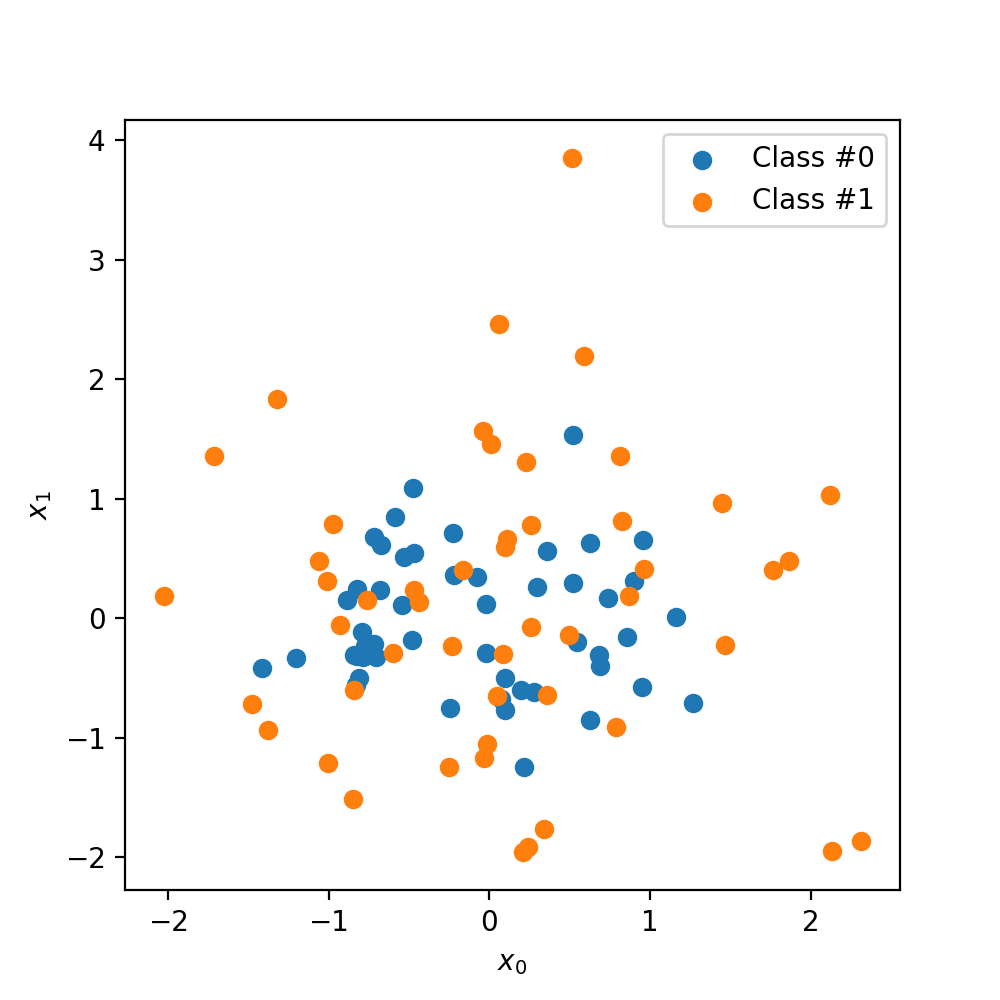

In [52]:
def select_class(X, y, class_val=1):
    return np.array([X[i] for i in range(len(y)) if y[i] == class_val])

np.random.seed(42)
n = 100
d = 4
X = np.random.randn(n, d)
m = np.median(np.linalg.norm(X, axis=1))
y = np.array([1 if np.linalg.norm(x) >= m else 0 for x in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)

# X = relu(np.dot(X, np.random.randn(4,2)))
c0 = select_class(X, y, class_val=0)
c1 = select_class(X, y, class_val=1)
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.scatter(c0[:, 0], c0[:, 1], label='Class #0')
ax.scatter(c1[:, 0], c1[:, 1], label='Class #1')
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.legend()

In [26]:
np.random.seed(42)
num_individuals = 20
num_epochs = 5
num_generations = 1000
cull = 0.75
batch_size = None
layers = (d, 2, 1)
use_pca = (False,False,)
population = Population(
    individual_factory=NeuralNetworkWithPCA,
    num=num_individuals,
    cull=cull,
    num_generations=num_generations,
    num_epochs=num_epochs,
    batch_size=batch_size,
    layers=layers,
    use_pca=use_pca,
)
population.fit(X_train, y_train[:, None])

Fitting generation 0 of 1000
Fitting generation 1 of 1000
Fitting generation 2 of 1000
Fitting generation 3 of 1000
Fitting generation 4 of 1000
Fitting generation 5 of 1000
Fitting generation 6 of 1000
Fitting generation 7 of 1000
Fitting generation 8 of 1000
Fitting generation 9 of 1000
Fitting generation 10 of 1000
Fitting generation 11 of 1000
Fitting generation 12 of 1000
Fitting generation 13 of 1000
Fitting generation 14 of 1000
Fitting generation 15 of 1000
Fitting generation 16 of 1000
Fitting generation 17 of 1000
Fitting generation 18 of 1000
Fitting generation 19 of 1000
Fitting generation 20 of 1000
Fitting generation 21 of 1000
Fitting generation 22 of 1000
Fitting generation 23 of 1000
Fitting generation 24 of 1000
Fitting generation 25 of 1000
Fitting generation 26 of 1000
Fitting generation 27 of 1000
Fitting generation 28 of 1000
Fitting generation 29 of 1000
Fitting generation 30 of 1000
Fitting generation 31 of 1000
Fitting generation 32 of 1000
Fitting generation 3

Fitting generation 279 of 1000
Fitting generation 280 of 1000
Fitting generation 281 of 1000
Fitting generation 282 of 1000
Fitting generation 283 of 1000
Fitting generation 284 of 1000
Fitting generation 285 of 1000
Fitting generation 286 of 1000
Fitting generation 287 of 1000
Fitting generation 288 of 1000
Fitting generation 289 of 1000
Fitting generation 290 of 1000
Fitting generation 291 of 1000
Fitting generation 292 of 1000
Fitting generation 293 of 1000
Fitting generation 294 of 1000
Fitting generation 295 of 1000
Fitting generation 296 of 1000
Fitting generation 297 of 1000
Fitting generation 298 of 1000
Fitting generation 299 of 1000
Fitting generation 300 of 1000
Fitting generation 301 of 1000
Fitting generation 302 of 1000
Fitting generation 303 of 1000
Fitting generation 304 of 1000
Fitting generation 305 of 1000
Fitting generation 306 of 1000
Fitting generation 307 of 1000
Fitting generation 308 of 1000
Fitting generation 309 of 1000
Fitting generation 310 of 1000
Fitting 

Fitting generation 544 of 1000
Fitting generation 545 of 1000
Fitting generation 546 of 1000
Fitting generation 547 of 1000
Fitting generation 548 of 1000
Fitting generation 549 of 1000
Fitting generation 550 of 1000
Fitting generation 551 of 1000
Fitting generation 552 of 1000
Fitting generation 553 of 1000
Fitting generation 554 of 1000
Fitting generation 555 of 1000
Fitting generation 556 of 1000
Fitting generation 557 of 1000
Fitting generation 558 of 1000
Fitting generation 559 of 1000
Fitting generation 560 of 1000
Fitting generation 561 of 1000
Fitting generation 562 of 1000
Fitting generation 563 of 1000
Fitting generation 564 of 1000
Fitting generation 565 of 1000
Fitting generation 566 of 1000
Fitting generation 567 of 1000
Fitting generation 568 of 1000
Fitting generation 569 of 1000
Fitting generation 570 of 1000
Fitting generation 571 of 1000
Fitting generation 572 of 1000
Fitting generation 573 of 1000
Fitting generation 574 of 1000
Fitting generation 575 of 1000
Fitting 

Fitting generation 821 of 1000
Fitting generation 822 of 1000
Fitting generation 823 of 1000
Fitting generation 824 of 1000
Fitting generation 825 of 1000
Fitting generation 826 of 1000
Fitting generation 827 of 1000
Fitting generation 828 of 1000
Fitting generation 829 of 1000
Fitting generation 830 of 1000
Fitting generation 831 of 1000
Fitting generation 832 of 1000
Fitting generation 833 of 1000
Fitting generation 834 of 1000
Fitting generation 835 of 1000
Fitting generation 836 of 1000
Fitting generation 837 of 1000
Fitting generation 838 of 1000
Fitting generation 839 of 1000
Fitting generation 840 of 1000
Fitting generation 841 of 1000
Fitting generation 842 of 1000
Fitting generation 843 of 1000
Fitting generation 844 of 1000
Fitting generation 845 of 1000
Fitting generation 846 of 1000
Fitting generation 847 of 1000
Fitting generation 848 of 1000
Fitting generation 849 of 1000
Fitting generation 850 of 1000
Fitting generation 851 of 1000
Fitting generation 852 of 1000
Fitting 

In [27]:
population.score(X_test, y_test[:, None])

[0.64,
 0.64,
 0.64,
 0.64,
 0.64,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48]

<IPython.core.display.Javascript object>


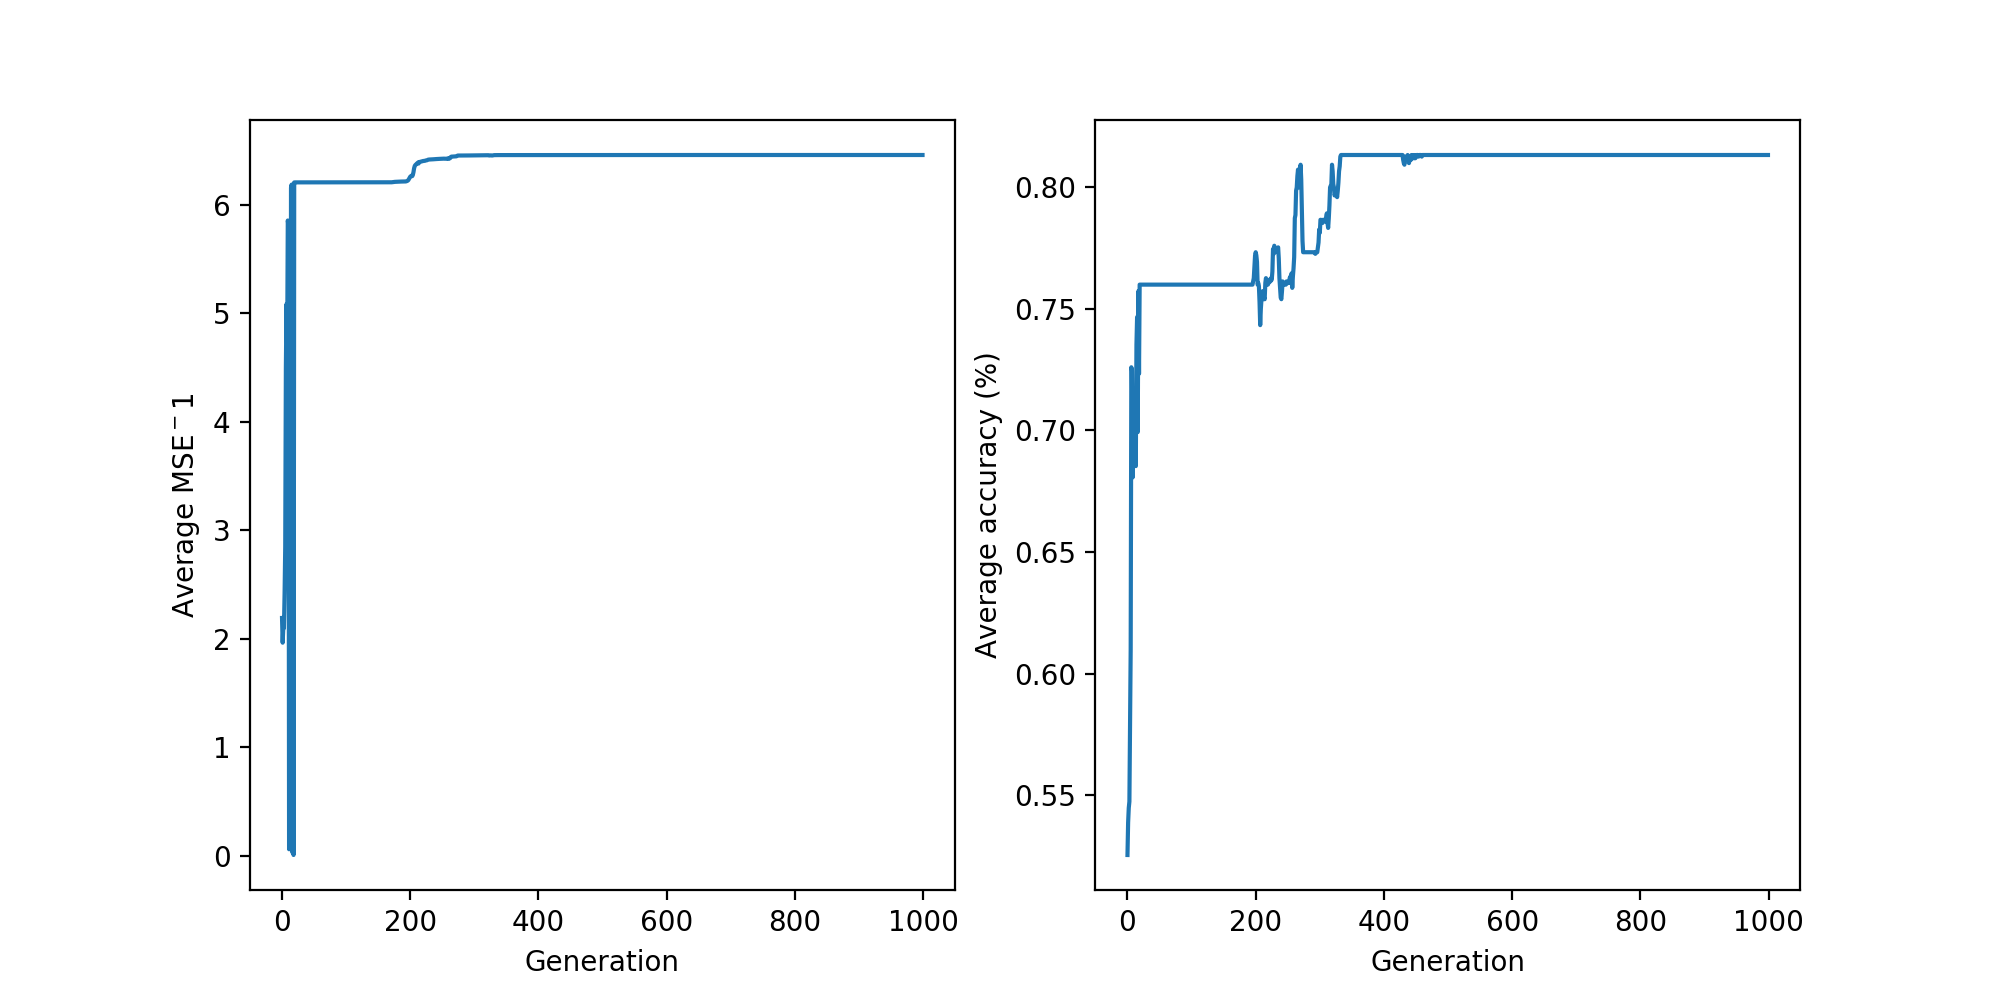

Text(0,0.5,'Average accuracy (%)')

In [28]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax.plot(np.array(population.mse)**-1)
ax2.plot(population.accuracy)
# for i in population.population:
#     nn = i.learner
#     ax.plot(nn.mse**-1)
#     ax2.plot(nn.accuracy)
ax.set_xlabel("Generation")
ax2.set_xlabel("Generation")
ax.set_ylabel("Average MSE$^-1$")
ax2.set_ylabel("Average accuracy (%)")

<IPython.core.display.Javascript object>


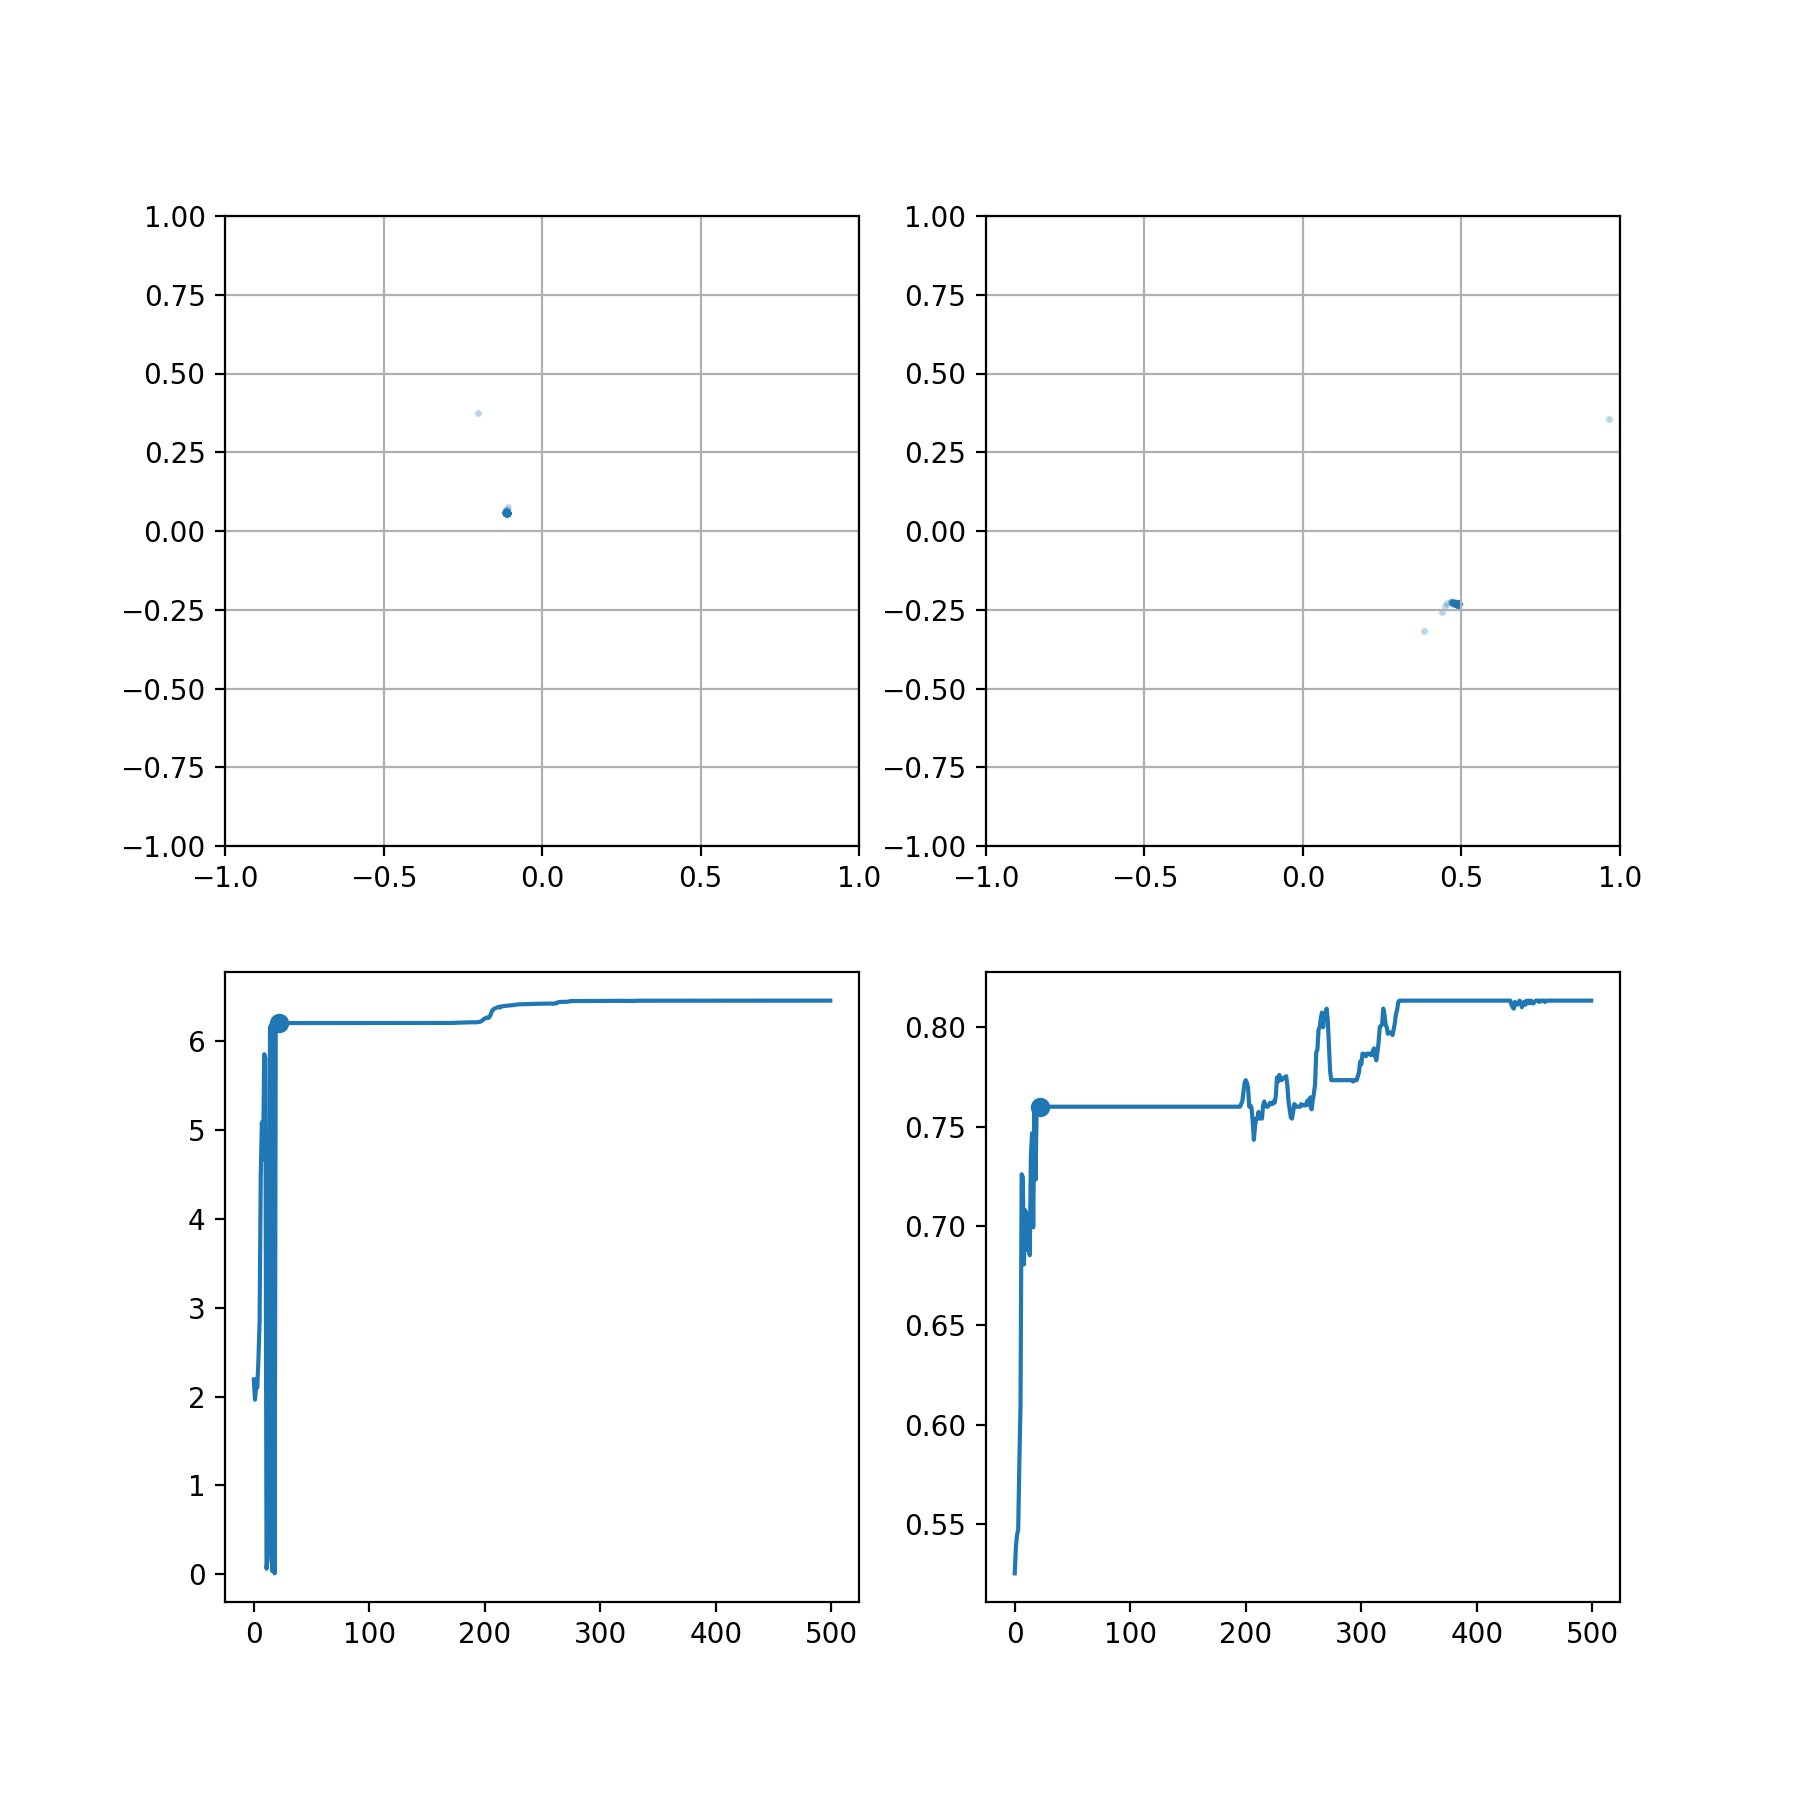

HBox(children=(Play(value=0, max=500), IntSlider(value=0, max=500)))

In [103]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

max_gen = min(num_generations-1, 500)

# @interact(generation=(0, num_generations-1))
generations = Play(interval=100,value=0,min=0,max=max_gen,step=1)
slider = IntSlider(value=0,min=0,max=max_gen,step=1)
widgets.jslink((generations, 'value'), (slider, 'value'))
# @interact(generation=generations)
def update(generation):
    layer = 0
    lookback = 5
    ax.cla()
    ax2.cla()
    ax.grid()
    ax2.grid()
    for i in range(lookback):
        if generation - i >= 0:
            h = population.population_history[generation - i]
            w0 = np.array([w[layer][0] for w in h])
            w1 = np.array([w[layer][1] for w in h])
            alpha = 1-i/lookback
            ax.scatter(w0[:,0], w0[:,1], color='C0', s=3, alpha=alpha)
            ax2.scatter(w1[:,0], w1[:,1], color='C0', s=3, alpha=alpha)
    ax.set_xbound(lower=-1,upper=1)
    ax.set_ybound(lower=-1,upper=1)
    ax2.set_xbound(lower=-1,upper=1)
    ax2.set_ybound(lower=-1,upper=1)
    
    ax3.cla()
    ax4.cla()
    ax3.plot((population.mse**-1)[:max_gen])
    ax3.scatter(generation, (population.mse**-1)[generation])
    ax4.plot(population.accuracy[:max_gen])
    ax4.scatter(generation, population.accuracy[generation])

out = widgets.interactive_output(update, {'generation': generations})
display(widgets.HBox([generations, slider]))

In [18]:
h = population.population_history[500]

In [20]:
h

[[array([[ 1.64233573, -0.1291425 ],
         [-2.03306887,  0.15843375]]), array([[ 0.25812163],
         [ 2.90911822]])], [array([[ 1.64236336, -0.12911766],
         [-2.03315288,  0.15847127]]), array([[ 0.25804961],
         [ 2.90919455]])], [array([[ 1.64236569, -0.129118  ],
         [-2.03315128,  0.15847843]]), array([[ 0.25805401],
         [ 2.90919899]])], [array([[ 1.64236507, -0.12911999],
         [-2.03315574,  0.15847482]]), array([[ 0.2580487 ],
         [ 2.90919488]])], [array([[ 1.64236079, -0.12911462],
         [-2.03315533,  0.15847509]]), array([[ 0.25804804],
         [ 2.9091935 ]])], [array([[ 1.6424358 , -0.12918342],
         [-2.03269833,  0.15888766]]), array([[ 0.25838678],
         [ 2.90927489]])], [array([[ 1.64236383, -0.12911738],
         [-2.03315349,  0.15847115]]), array([[ 0.25804935],
         [ 2.9091954 ]])], [array([[ 1.6423673 , -0.12912236],
         [-2.03315   ,  0.15848319]]), array([[ 0.2580467],
         [ 2.9091943]])], [array([[

In [126]:
w

array([[ 1.64233573, -0.1291425 ],
       [ 1.64236336, -0.12911766],
       [ 1.64236569, -0.129118  ],
       [ 1.64236507, -0.12911999],
       [ 1.64236079, -0.12911462],
       [ 1.6424358 , -0.12918342],
       [ 1.64236383, -0.12911738],
       [ 1.6423673 , -0.12912236],
       [ 1.6423656 , -0.12911922],
       [ 1.64236154, -0.12911388],
       [ 1.64218827, -0.12929396],
       [ 1.64236375, -0.12911647],
       [ 1.64235272, -0.1291261 ],
       [ 1.6423645 , -0.12911897],
       [ 1.64236182, -0.12911474],
       [ 1.6425586 , -0.12936453],
       [ 1.64236248, -0.12911891],
       [ 1.6423721 , -0.12912657],
       [ 1.64236569, -0.1291206 ],
       [ 1.64236134, -0.12911451]])

<IPython.core.display.Javascript object>


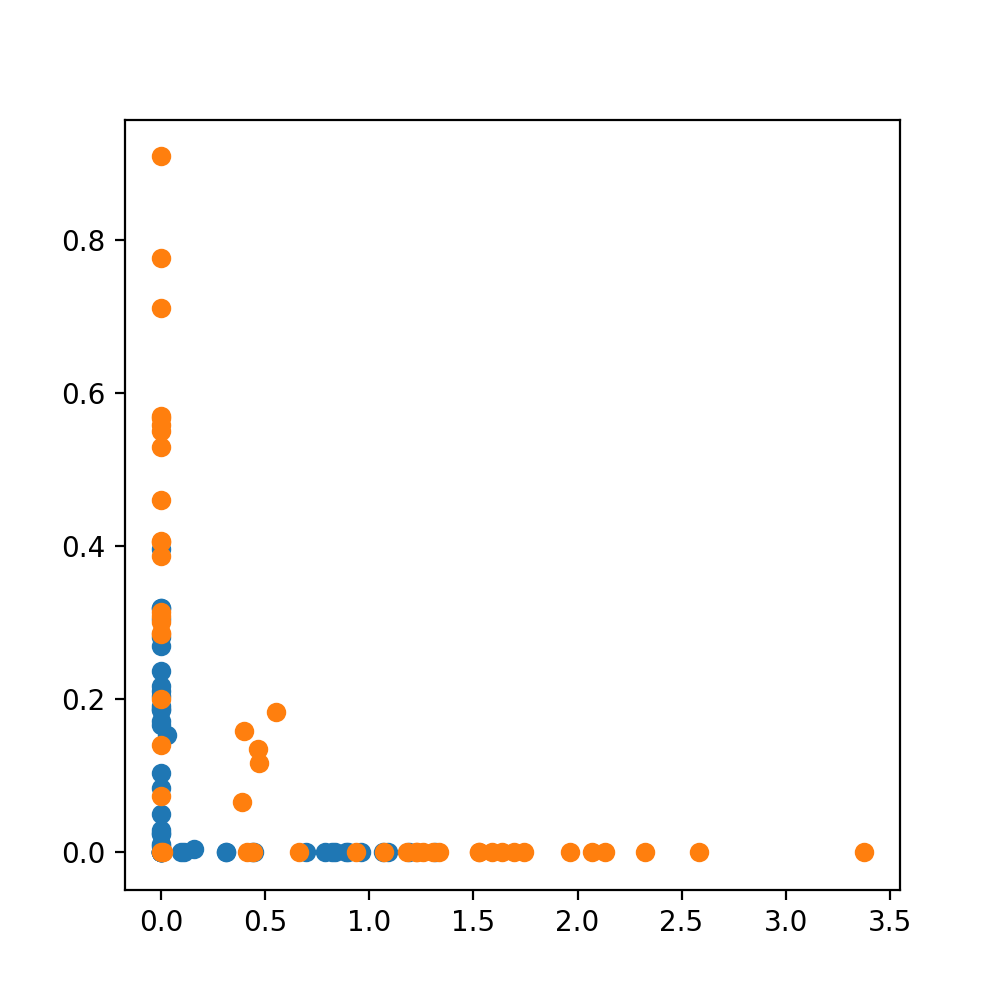

interactive(children=(IntSlider(value=499, description='generation', max=999), Output()), _dom_classes=('widget-interact',))

In [64]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
activation = relu
layer = 0
@interact(generation=(0,population.num_generations-1))
def update(generation):
    best_weights = population.population_history[generation][0]
    xt = activation(np.dot(X, best_weights[layer]))
#     xt = np.dot(X, best_weights[layer])
    xt0 = select_class(xt, y, class_val=0)
    xt1 = select_class(xt, y, class_val=1)
    ax.cla()
    ax.scatter(xt0[:,0], xt0[:,1])
    ax.scatter(xt1[:,0], xt1[:,1])

<IPython.core.display.Javascript object>


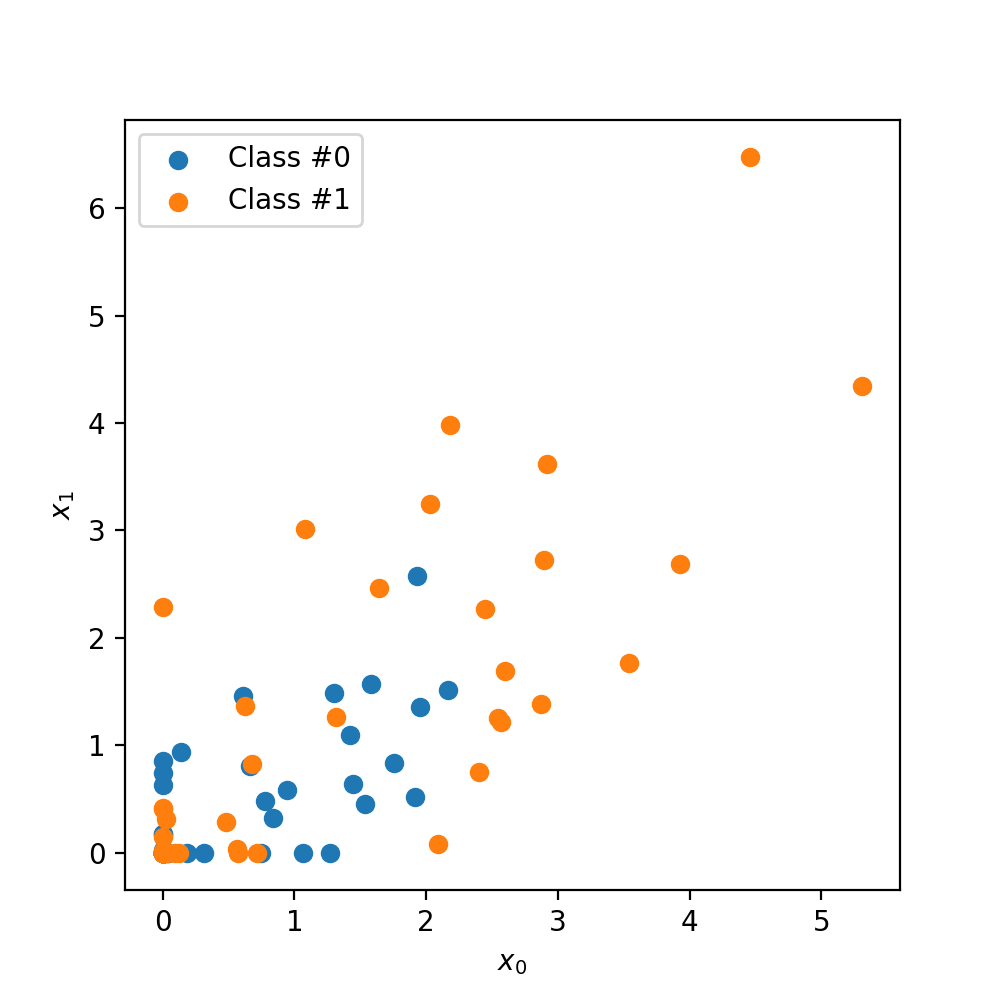

In [60]:
best_weights = population.population_history[0][0]
xt = relu(np.dot(X, best_weights[0]))
c0 = select_class(xt, y, class_val=0)
c1 = select_class(xt, y, class_val=1)
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.scatter(c0[:, 0], c0[:, 1], label='Class #0')
ax.scatter(c1[:, 0], c1[:, 1], label='Class #1')
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.legend()